**Import libraries and create Spark Session**

In [68]:
import findspark 
findspark.init('/home/surbhi/Downloads/spark-2.2.0-bin-hadoop2.7')

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number
from pyspark.sql.functions import (dayofmonth, hour,
                                   dayofyear, month,
                                   year, weekofyear,
                                  format_number, date_format)

spark = SparkSession.builder.master("local").appName("microsoft").config("spark.executor.memory", "3g").getOrCreate()

In [69]:
df = spark.read.csv('microsoftNew.csv', inferSchema=True, header=True)

**What are the column names?**

In [70]:
df.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

**What does the Schema look like?**

In [71]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



**Print out the first 5 columns.**

In [72]:
for line in df.head(5):
    print(line, '\n')

Row(Date=datetime.datetime(2018, 10, 30, 0, 0), Open=103.660004, High=104.379997, Low=100.110001, Close=103.730003, Volume=65350900, Adj Close=103.730003) 

Row(Date=datetime.datetime(2018, 10, 29, 0, 0), Open=108.110001, High=108.699997, Low=101.629997, Close=103.849998, Volume=55162000, Adj Close=103.849998) 

Row(Date=datetime.datetime(2018, 10, 26, 0, 0), Open=105.690002, High=108.75, Low=104.760002, Close=106.959999, Volume=55523100, Adj Close=106.959999) 

Row(Date=datetime.datetime(2018, 10, 25, 0, 0), Open=106.550003, High=109.269997, Low=106.150002, Close=108.300003, Volume=61646800, Adj Close=108.300003) 

Row(Date=datetime.datetime(2018, 10, 24, 0, 0), Open=108.410004, High=108.489998, Low=101.589996, Close=102.32, Volume=63897800, Adj Close=102.32) 



**Use describe function to learn about the DataFrame.**

In [73]:
df.describe().show()

+-------+------------------+-----------------+-----------------+------------------+--------------------+------------------+
|summary|              Open|             High|              Low|             Close|              Volume|         Adj Close|
+-------+------------------+-----------------+-----------------+------------------+--------------------+------------------+
|  count|              4738|             4738|             4738|              4738|                4738|              4738|
|   mean|37.026357026593516|37.41019501477407|36.64333786196699| 37.02922352195016|5.7082246707471505E7|31.650932395947663|
| stddev|18.635902942222035|18.75697105849408| 18.4835945869743|18.632471980918663|3.1630636929271787E7|20.173438768548856|
|    min|              15.2|            15.62|            14.87|             15.15|             7425600|         11.956082|
|    max|        115.419998|           116.18|           114.93|        115.610001|           591052200|        115.610001|
+-------

**Formatting the column values to limit the values to show up to two decimal places.**

In [74]:
summary = df.describe()
summary.select(summary['summary'],
                  format_number(summary['Open'].cast('float'), 2).alias('Open'),
                  format_number(summary['High'].cast('float'), 2).alias('High'),
                  format_number(summary['Low'].cast('float'), 2).alias('Low'),
                  format_number(summary['Close'].cast('float'), 2).alias('Close'),
                  format_number(summary['Volume'].cast('int'),0).alias('Volume')
                 ).show()



+-------+--------+--------+--------+--------+-----------+
|summary|    Open|    High|     Low|   Close|     Volume|
+-------+--------+--------+--------+--------+-----------+
|  count|4,738.00|4,738.00|4,738.00|4,738.00|      4,738|
|   mean|   37.03|   37.41|   36.64|   37.03|       null|
| stddev|   18.64|   18.76|   18.48|   18.63|       null|
|    min|   15.20|   15.62|   14.87|   15.15|  7,425,600|
|    max|  115.42|  116.18|  114.93|  115.61|591,052,200|
+-------+--------+--------+--------+--------+-----------+



**Feature Engineering: Create a new dataframe by adding a new feature called HV Ratio i.e. the ratio of the High Price versus volume of stock traded for a day.**

In [75]:
df_hv = df.withColumn('HV Ratio', df['High']/df['Volume']).select(['HV Ratio'])
df_hv.show()

+--------------------+
|            HV Ratio|
+--------------------+
|1.597223557747483...|
|1.970559388709618...|
|1.958644239964987...|
|1.772516935185605...|
|1.697867500915524...|
|2.489582023467914...|
|4.164155302573685E-6|
|3.381372893504750...|
|3.400274378426269...|
|4.211584890877724E-6|
|3.524495384401237...|
|3.413984707544257E-6|
|2.330018956015759...|
|1.704580129975604...|
|1.816662131800059...|
|4.316261250601177E-6|
|3.779613064512864E-6|
|3.893164103216841E-6|
|3.295646163168369E-6|
|6.978616049975974E-6|
+--------------------+
only showing top 20 rows



**What day had the peak High in Price?**

In [76]:
df.orderBy(df['High'].desc()).select(['Date']).head(1)[0]['Date']

datetime.datetime(2018, 10, 3, 0, 0)

**What is the mean of the Close column?**

In [77]:
from pyspark.sql.functions import mean

df.select(mean('Close')).show()

+-----------------+
|       avg(Close)|
+-----------------+
|37.02922352195016|
+-----------------+



**What is the max and min of the Volume column?**

In [78]:
from pyspark.sql.functions import min, max

df.select(max('Volume'),min('Volume')).show()

+-----------+-----------+
|max(Volume)|min(Volume)|
+-----------+-----------+
|  591052200|    7425600|
+-----------+-----------+



**How many days was the closing lower than avg. value of Close?**

In [79]:
df.filter(df['Close'] < 37.02922352195016).count()

3414

**What percentage of the time was the High greater than threshold?**

In [99]:
df.filter('High > 38').count() * 100/df.count()

27.226677923174336

**What is the Pearson correlation between High and Volume?**

In [81]:
df.corr('High', 'Volume')

-0.424408321291648

**What is the max High per year?**

In [82]:
from pyspark.sql.functions import (dayofmonth, hour,
                                   dayofyear, month,
                                   year, weekofyear,
                                  format_number, date_format)

year_df = df.withColumn('Year', year(df['Date']))
#year_df.show(n=500)
year_new_df = year_df.groupBy('Year').max()['Year', 'max(High)']
year_new_df.show()

#all the years in the dataset
#year_new_df.coalesce(1).write.option("header", "false").csv("year.csv")

+----+---------+
|Year|max(High)|
+----+---------+
|2003|     30.0|
|2007|     37.5|
|2018|   116.18|
|2015|56.849998|
|2006|    30.26|
|2013|    38.98|
|2014|50.049999|
|2004|30.200001|
|2012|32.950001|
|2009|     31.5|
|2016|64.099998|
|2001|38.075001|
|2005|    28.25|
|2000|  59.3125|
|2010|    31.58|
|2011|29.459999|
|2008|35.959999|
|2017|     87.5|
|2002|35.310001|
+----+---------+



**What is the average Close for each Calendar Month? I.e. across all the years, what is the average Close price for Jan, Feb, Mar, etc.**

In [83]:
import pandas as pd
#All the months from all the years in the dataset
#Create a new column Month from existing Date column
month_df = df.withColumn('Month', month(df['Date']))
#month_df.show(n=500)
#Group by month and take average of all other columns
month1_df = month_df.groupBy('Month').mean()

#Sort by month
month1_df = month1_df.orderBy('Month')

#Display only month and avg(Close), the desired columns
month_new_df = month1_df['Month', 'avg(Close)']
month_new_df.show()

+-----+------------------+
|Month|        avg(Close)|
+-----+------------------+
|    1|37.235892825974005|
|    2|36.358448646575326|
|    3|36.361752183132545|
|    4| 36.40331635714283|
|    5| 36.83652537376236|
|    6| 37.03310339901478|
|    7| 37.53589384999999|
|    8| 38.04809403073286|
|    9| 37.73058580628271|
|   10|38.300537064439126|
|   11| 36.30581183423913|
|   12|35.962892548812654|
+-----+------------------+



**What is the max High for each Calendar Month? I.e. across all the years, what is the average Close price for Jan, Feb, Mar, etc.**

In [84]:
#Max high in a month
month_new1_df = month_df.groupBy('Month').max()['Month', 'max(High)']
month_new1_df.show()

#month_new1_df.coalesce(1).write.option("header", "false").csv("month.csv")

+-----+----------+
|Month| max(High)|
+-----+----------+
|   12|      87.5|
|    1| 95.449997|
|    6|102.690002|
|    3| 97.239998|
|    5| 99.989998|
|    9|115.290001|
|    4| 97.900002|
|    8|112.779999|
|    7|111.150002|
|   10|    116.18|
|   11| 85.059998|
|    2|     96.07|
+-----+----------+



**SparkSQL**

In [89]:
df.createOrReplaceTempView("stock")
sqlStock = spark.sql("SELECT * FROM stock")
sqlStock.show()

+-------------------+----------+----------+----------+----------+--------+----------+
|               Date|      Open|      High|       Low|     Close|  Volume| Adj Close|
+-------------------+----------+----------+----------+----------+--------+----------+
|2018-10-30 00:00:00|103.660004|104.379997|100.110001|103.730003|65350900|103.730003|
|2018-10-29 00:00:00|108.110001|108.699997|101.629997|103.849998|55162000|103.849998|
|2018-10-26 00:00:00|105.690002|    108.75|104.760002|106.959999|55523100|106.959999|
|2018-10-25 00:00:00|106.550003|109.269997|106.150002|108.300003|61646800|108.300003|
|2018-10-24 00:00:00|108.410004|108.489998|101.589996|    102.32|63897800|    102.32|
|2018-10-23 00:00:00|107.769997|108.970001|105.110001|108.099998|43770400|108.099998|
|2018-10-22 00:00:00|    109.32|110.540001|108.239998|109.629997|26545600|109.629997|
|2018-10-19 00:00:00|    108.93|110.860001|108.209999|108.660004|32785500|108.660004|
|2018-10-18 00:00:00|110.099998|110.529999|107.830002|

In [90]:
sqlStock = spark.sql("SELECT * FROM stock WHERE Date = '2018-10-30 00:00:00'")
sqlStock.show()

+-------------------+----------+----------+----------+----------+--------+----------+
|               Date|      Open|      High|       Low|     Close|  Volume| Adj Close|
+-------------------+----------+----------+----------+----------+--------+----------+
|2018-10-30 00:00:00|103.660004|104.379997|100.110001|103.730003|65350900|103.730003|
+-------------------+----------+----------+----------+----------+--------+----------+



**What are the column names and what does the Schema look like?**

In [91]:
spark.sql("SELECT * FROM stock")

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Volume: int, Adj Close: double]

**What was the peak high and which date had the peak high in Price?**

In [97]:
spark.sql("SELECT max(High) FROM stock").show()
spark.sql("SELECT * FROM stock WHERE High = 116.18").show()

+---------+
|max(High)|
+---------+
|   116.18|
+---------+

+-------------------+----------+------+------+----------+--------+----------+
|               Date|      Open|  High|   Low|     Close|  Volume| Adj Close|
+-------------------+----------+------+------+----------+--------+----------+
|2018-10-03 00:00:00|115.419998|116.18|114.93|115.169998|16648000|115.169998|
+-------------------+----------+------+------+----------+--------+----------+



In [93]:
sqlStock = spark.sql("SELECT avg(Close) FROM stock")
sqlStock.show()

+-----------------+
|       avg(Close)|
+-----------------+
|37.02922352195016|
+-----------------+



In [94]:
sqlStock = spark.sql("SELECT max(Volume),min(Volume) FROM stock")
sqlStock.show()

+-----------+-----------+
|max(Volume)|min(Volume)|
+-----------+-----------+
|  591052200|    7425600|
+-----------+-----------+



In [95]:
sqlStock = spark.sql("SELECT COUNT(*) Days FROM stock WHERE Close < 37.02922352195016")
sqlStock.show()

+----+
|Days|
+----+
|3414|
+----+



In [71]:
#import pandas as pd
#import matplotlib.pyplot as plt 
#df = pd.read_csv('microsoftNew.csv')
#df_original = df.copy() # Copy to have a version of df without modifications
#df.head()

#df.hist(figsize=(10,10))
#plt.show()

**Visualization**

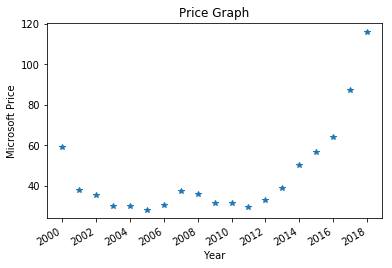

In [68]:
from __future__ import print_function
from matplotlib.dates import strpdate2num
import numpy as np
from pylab import figure, show
import matplotlib.cbook as cbook

def bytespdate2num(fmt, encoding='utf-8'):
    strconverter = strpdate2num(fmt)
    def bytesconverter(b):
        s = b.decode(encoding)
        return strconverter(s)
    return bytesconverter


#datafile = cbook.get_sample_data('/home/surbhi/Downloads/sitc-master/microsoftNew.csv', asfileobj=False)
datafile = cbook.get_sample_data('/home/surbhi/Downloads/sitc-master/year.csv/yearFloat.csv', asfileobj=False)
#print('loading', datafile)

dates, closes = np.loadtxt(
    datafile, delimiter=',',
    converters={0:bytespdate2num('%Y')}, #'%Y-%m-%d'
    skiprows=0, usecols=(0,1), unpack=True) #skiprows=1, usecols=(0,2), unpack=True) 

fig = figure()
ax = fig.add_subplot(111)
ax.plot_date(dates, closes, '*')
ax.set_xlabel('Year')
ax.set_ylabel('Microsoft Price')
ax.set_title('Price Graph')
fig.autofmt_xdate()